## skpro probability distributions

**Set-up instructions:** On binder, this should run out-of-the-box.

To run locally instead, ensure that `skpro` with basic dependency requirements is installed in your python environment.

`skpro` provides a unified interface to probability distributions, with an API that:

* is `scikit-learn` and `scikit-base` compliant, parametric objects with `get_params`, `set_params`
* allows to represent data frame and 2D arrays of distributions easily, as return objects in `predict_proba`
* is `pandas` copmliant, with `index`, `columns`, indexing and subsetting via `iloc`, `loc`
* provides easy access to informative and didactic vicualizations via `matplotlib`

**Section 1** provides an **overview of core API elements**

**Section 2** gives an overview of **distribution object methods**, relevant tags and configs

**Section 3** introduces **composite distributions** and related APIs

**Section 4** gives an introduction to writing API compliant **custom probability distributions**

In [1]:
# hide warnings
import warnings

warnings.filterwarnings("ignore")

## 1. `skpro` probability distributions <a class="anchor" id="chapter1"></a>

### 1.1 probability distributions base interface

`skpro` distributions are parametric objects:

In [2]:
from skpro.distributions import Normal

# defining a normal distribution with mean 1 and std 2
n = Normal(mu=1, sigma=2)

n

Normal(mu=1, sigma=2)

The object `n` is a symbolic representation of a normal distribution.

The object provides various useful methods:

* properties and functions such as `pdf`, `cdf`, `mean`, `var`
* a method to sample from the distribution, `sample`
* a method to visualize the distribution, `plot`

<Axes: xlabel='x', ylabel='pdf(x)'>

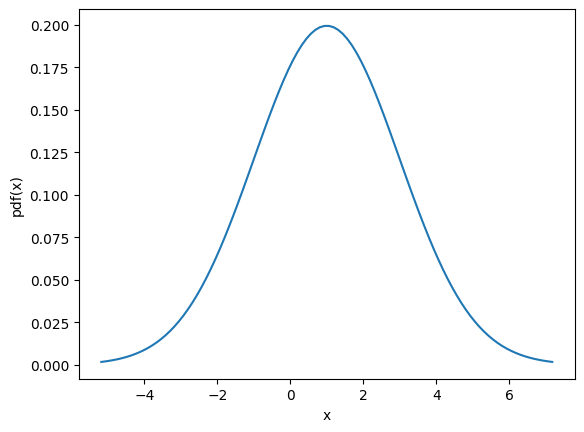

In [3]:
n.plot("pdf")

In [4]:
# evaluate the pdf, compare the figure
n.pdf(2)

0.17603266338214976

In [5]:
# mean/expectation of the distribution
# same as mu, for normal
n.mean()

1

In [6]:
# variance of the distribution
# same as sigma-squared, for normal
n.var()

4

<Axes: xlabel='x', ylabel='cdf(x)'>

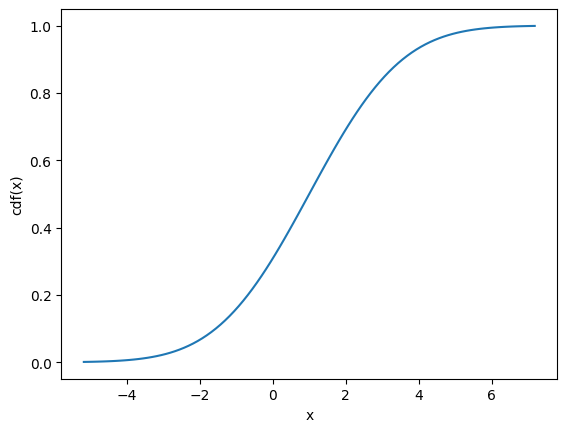

In [7]:
# plot the cdf
n.plot("cdf")

In [8]:
n.cdf(1)

0.5

the `sample` method can be used to produce a single independent sample, or multiple:

In [9]:
# produce single sample
n.sample()

1.1912741216529632

In [10]:
# produce an i.i.d. sample of size 10
n.sample(10)
# returned as a pd.DataFrame

,0
0,3.625458
1,-0.246548
2,-1.406921
3,-0.191985
4,0.635711
5,2.325129
6,1.231040
7,2.408127
8,2.975574
9,0.996685


parameters can be set and accessed via `get_params`, `set_params` - like in `scikit-learn`

In [11]:
n.get_params()

{'columns': None, 'index': None, 'mu': 1, 'sigma': 2}

### 1.2 DataFrame-like distributions, array distributions

`skpro` distributions are designed to easily represent DataFrame-like distributions,

i.e., array distributions with row (instance) index and column (variable) index

all distributions can be constructed as a DataFrame-like distribution:

In [12]:
from skpro.distributions import Normal

instance_names = [1, 2, 3]
variable_names = ["foo", "bar"]

# the syntax is similar to pandas:
# parameters passed as arrays
# index, columns passed

mus = [[1, 2], [2, 3], [3, 4]]
sigmas = [[1, 1], [2, 1], [1, 2]]
n = Normal(mu=mus, sigma=sigmas, index=instance_names, columns=variable_names)

`n` represents a joint distribution of independent normals in an array, with row and column index

(most) methods behave as applying array input to marginals

e.g., visualisation:

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'foo'}, ylabel='1'>,
         <Axes: title={'center': 'bar'}>],
        [<Axes: ylabel='2'>, <Axes: >],
        [<Axes: ylabel='3'>, <Axes: >]], dtype=object))

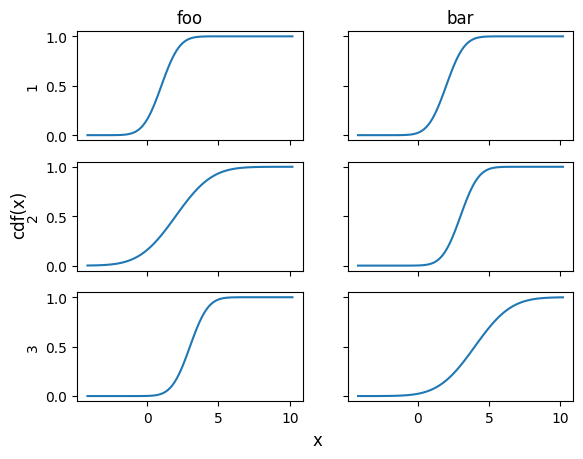

In [13]:
n.plot("cdf")

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'foo'}, ylabel='1'>,
         <Axes: title={'center': 'bar'}>],
        [<Axes: ylabel='2'>, <Axes: >],
        [<Axes: ylabel='3'>, <Axes: >]], dtype=object))

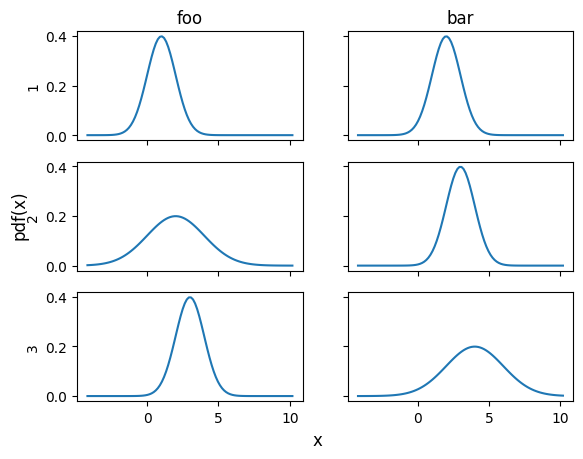

In [14]:
n.plot("pdf")

In [15]:
# sampling produces DataFrame with same index, columns
n.sample()

,foo,bar
1,0.626937,2.388353
2,-0.010153,2.536991
3,2.561095,5.851512


In [16]:
# same for mean
n.mean()

,foo,bar
1,1,2
2,2,3
3,3,4


In [17]:
# variance
n.var()

,foo,bar
1,1,1
2,4,1
3,1,4


methods with arguments broadcast to 2D

In [18]:
# methods with arguments broadcast
n.pdf(1)

,foo,bar
1,0.398942,0.241971
2,0.176033,0.053991
3,0.053991,0.064759


In [19]:
# 1D is considered as a row when broadcasting
n.pdf([1, 100])

,foo,bar
1,0.398942,0.0
2,0.176033,0.0
3,0.053991,0.0


In [20]:
# to broadcast column-wise, use 2D column vector
n.pdf([[1], [2], [100]])

,foo,bar
1,0.398942,0.241971
2,0.199471,0.241971
3,0.000000,0.000000


In [21]:
# 2D is evaluated entry-wise
n.pdf([[1, 2], [3, 5], [5, 7]])

,foo,bar
1,0.398942,0.398942
2,0.176033,0.053991
3,0.053991,0.064759


`skpro` distribution objects are pandas-like!

In [22]:
n.shape

(3, 2)

`index` and `columns` are coerced to `pandas.Index` subtypes

In [23]:
n.index

Index([1, 2, 3], dtype='int64')

In [24]:
n.columns  # same columns as X_new

Index(['foo', 'bar'], dtype='object')

subsetting with `iloc` (integer location) and `loc` works as in `pandas`:

* `iloc[rows, cols]` and `loc[rows, cols]` subset to an array distribution
* `iat[row, col]` and `at[row, col]` subset to a scalar distribution

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'bar'}, ylabel='1'>, <Axes: ylabel='3'>],
       dtype=object))

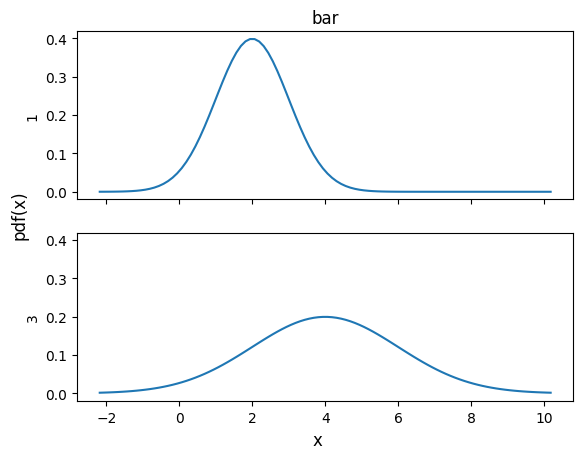

In [25]:
# we wubset to two rows and one column
n_subset = n.iloc[[0, 2], [1]]
# n_subset.shape = (2, 1)
n_subset.plot()

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'bar'}, ylabel='1'>, <Axes: ylabel='3'>],
       dtype=object))

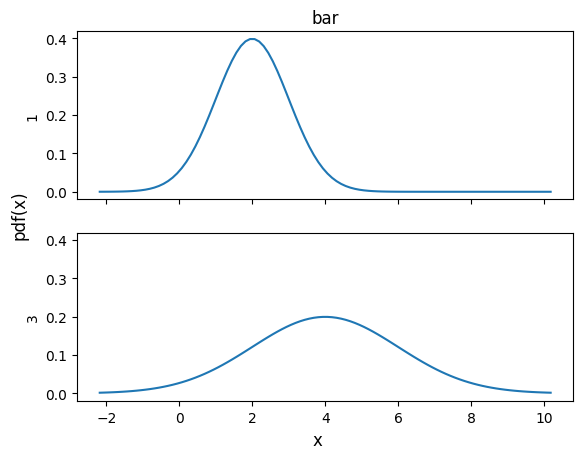

In [26]:
# same rows, cols, but with loc indexing
n_subset = n.loc[[1, 3], ["bar"]]
# n_subset.shape = (2, 1)
n_subset.plot()

In [27]:
# subsetting to a scalar distribution
n.at[1, "bar"]
# this behaves the same as the distribution in the previous section

Normal(mu=2.0, sigma=1.0)

### 1.3 DataFrame-like distributions - broadcasting

at construction, all (simple) probabilty distributions broadcast parameters:

* if `index` or `columns` are passed, always broadcasts to 2D
* 1D iterables are interpreted as row vectors, i.e., of shape (1, n)
* if `index` and `columns` are absent, and the result is 2D, uses `RangeIndex` (integers starting at 0)
* the result is a scalar distribution only if `index`, `columns` are not passed, and all parameters are zero-D (scalar)

In [28]:
# broadcasting example: index is passed
from skpro.distributions import Normal

n = Normal(mu=1, sigma=2, index=[1, 2, 3])
# results in a shape (3, 1) distribution, with all mu, sigma being 1, 2
n.shape

(3, 1)

In [29]:
n.mean()

,0
1,1
2,1
3,1


In [30]:
n.var()

,0
1,4
2,4
3,4


In [31]:
# broadcasting example: a parameter is non-scalar
from skpro.distributions import Normal

n = Normal(mu=[[1, 2], [2, 3]], sigma=2)
# results in a shape (2, 2) distribution
# sigma is broadcast ot the shape of mu
# index, columns are RangeIndex, i.e., [0, 1]
n.shape

(2, 2)

In [32]:
n.mean()

,0,1
0,1,2
1,2,3


In [33]:
# broadcasting example: 1D parameter is broadcast as a row
from skpro.distributions import Normal

n = Normal(mu=[1, 2, 3], sigma=2)
# results in a shape (1, 3) distribution
# mu is interpreted as (1, 3) row vector
# sigma is broadcast ot the shape of mu
# index, columns are RangeIndex, i.e., index=[0] and columns=[0, 1, 2]
n.shape

(1, 3)

In [34]:
n.mean()

,0,1,2
0,1,2,3


### 1.4 searching for probability distributions

as first-class citizens, all objects in `skpro` are indexed via the `registry` utility `all_objects`.

To find probabilisty distirbutions, use `all_objects` with the type `distribution`:

In [35]:
from skpro.registry import all_objects

all_objects("distribution", as_dataframe=True).head()

,name,object
0,Beta,<class 'skpro.distributions.beta.Beta'>
1,ChiSquared,<class 'skpro.distributions.chi_squared.ChiSqu...
2,Delta,<class 'skpro.distributions.delta.Delta'>
3,Empirical,<class 'skpro.distributions.empirical.Empirical'>
4,Fisk,<class 'skpro.distributions.fisk.Fisk'>


a full list can also be found in the online API reference.

all tags can be printed by the `all_tags` utility:

In [36]:
# all tags applicable to probability distribution
from skpro.registry import all_tags

all_tags("distribution", as_dataframe=True)

,name,scitype,type,description
0,approx_energy_spl,distribution,int,sample size used in MC estimates of energy
1,approx_mean_spl,distribution,int,sample size used in MC estimates of mean
2,approx_spl,distribution,int,sample size used in other MC estimates
3,approx_var_spl,distribution,int,sample size used in MC estimates of var
4,bisect_iter,distribution,int,max iters for bisection method in ppf
5,broadcast_init,distribution,"(str, [on, off])",whether to initialize broadcast parameters in ...
6,broadcast_inner,distribution,"(str, [array, scalar])",if inner logic is vectorized ('array') or scal...
7,broadcast_params,distribution,"(list, str)","distribution parameters to broadcast, compleme..."
8,capabilities:approx,distribution,"(list, str)",methods of distr that are approximate
9,capabilities:exact,distribution,"(list, str)",methods of distr that are numerically exact


filtering in search can be done with the `filter_tags` argument in `all_objects`, see docstring:

In [37]:
from skpro.registry import all_objects

# "retrieve all absolutely continuous distributions on the reals"
all_objects(
    "distribution", as_dataframe=True, filter_tags={"distr:measuretype": "continuous"}
)

,name,object
0,Beta,<class 'skpro.distributions.beta.Beta'>
1,ChiSquared,<class 'skpro.distributions.chi_squared.ChiSqu...
2,Fisk,<class 'skpro.distributions.fisk.Fisk'>
3,Laplace,<class 'skpro.distributions.laplace.Laplace'>
4,LogNormal,<class 'skpro.distributions.lognormal.LogNormal'>
5,Logistic,<class 'skpro.distributions.logistic.Logistic'>
6,Normal,<class 'skpro.distributions.normal.Normal'>
7,QPD_B,<class 'skpro.distributions.qpd.QPD_B'>
8,QPD_S,<class 'skpro.distributions.qpd.QPD_S'>
9,QPD_U,<class 'skpro.distributions.qpd.QPD_U'>


## 2. probability distributions - methods <a class="anchor" id="chapter2"></a>

This section presents an overview of methods of probability distributions, with mathematical references.

The section is separated into:

* common properties and distribution defining functions, such as `pdf`, `cdf`
* overview of tags, approximation configs
* uncommon and exotic properties and functions

For simplicity, the methods are presented only 

### 2.1 common distribution methods

Let $X$ be a random variable supported on the reals, with distribution represented by a (scalar) `skpro` distribution `d`.

In [38]:
from skpro.distributions import Normal

d = Normal(mu=1, sigma=2)

The following table lists common distribution methods with their meaning:

| Method   | English | Mathematical  | Arguments |
|----------|---|:-------------:|------|
| `mean` | expectation | $\mathbb{E}[X]$ | none |
| `var` | variance | $\mathbb{V}[X]$ | none |
| `cdf` | cumulative distribution function | $F_X(x) = P(X\le x)$ | `x`, for $x\in \mathbb{R}$ |
| `ppf` | percent point function or inverse cdf | $F_X^{-1}(p)$ | `p`, for $p\in [0, 1]$ |
| `pdf` | probability density function | $p_X(x) = (dp/dx) (x)$ | `x`, for $x\in \mathbb{R}$ |
| `pmf` | probability mass function | $m_X(x) = P(X = x)$ | `x`, for $x\in \mathbb{R}$ |

`skpro` can represent (absolutely) continuous, discrete, and mixed distributions over the reals (without singular part). All distributions possess `pmf`, and `pdf`, as the uniquely defined discrete resp continuous parts of the measure.

`mean` and `var` compute mean and variance, without arguments:

In [39]:
(d.mean(), d.var())

(1, 4)

`ppf` takes arguments in the range of $[0,1]$:

In [40]:
d.ppf(0.7)

2.0488010254160813

`cdf`, `pdf`, `pmf` take arguments on the domain of $X$, i.e., real numbers:

In [41]:
(d.cdf(1), d.pdf(2), d.pmf(3))

(0.5, 0.17603266338214976, array(0))

Note: as the normal distribution is absolutely continuous, it has no discrete part, and `pmf` will always return 0.

All methods can be displayed via `plot`:

<Axes: xlabel='x', ylabel='ppf(x)'>

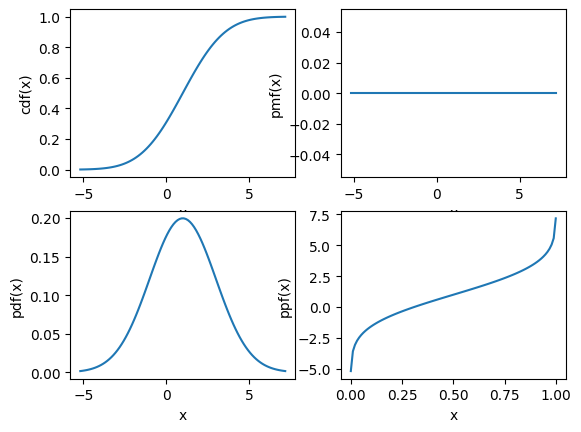

In [42]:
from matplotlib.pyplot import subplots
fig, ax = subplots(2, 2)

d.plot("cdf", ax=ax[0, 0])
d.plot("pmf", ax=ax[0, 1])
d.plot("pdf", ax=ax[1, 0])
d.plot("ppf", ax=ax[1, 1])

As explained in section 1, all methods generalize to dataframe-like distributions and broadcast arguments, see there. For instance:

In [43]:
from skpro.distributions import Normal

d_frame = Normal(mu=[[1, 2], [2, 3], [3, 4]], sigma=2)

d_frame.cdf(2)

,0,1
0,0.691462,0.500000
1,0.500000,0.308538
2,0.308538,0.158655


### 2.2 distribution tags and approximation configs

properties of distributions are also availbale as tags.

For instance, the tag `"distr:measuretype"` indicates whether the distribution is absolutely continuous, discrete, or mixed:

In [44]:
from skpro.distributions import Normal

d = Normal(mu=1, sigma=2)
d.get_tags()["distr:measuretype"]

'continuous'

the tags `capabilities:exact` and `capabilities:approx` indicate which methods are numerically exact, or approximative.

An approximative method may not be numerically exact, typically has lower accuracy or higher runtime.

For instance, the method may be computed using Monte Carlo estimates, or numerical integration.

In [45]:
d.get_tags()["capabilities:exact"]

['mean', 'var', 'energy', 'pdf', 'log_pdf', 'cdf', 'ppf']

In [46]:
d.get_tags()["capabilities:approx"]

['pdfnorm']

### 2.3 uncommon distribution methods

This section lists further, uncommon distribution methods.

Let $X$ be a random variable supported on the reals, with distribution represented by a (scalar) `skpro` distribution `d`.
Let $Y$ be an i.i.d. copy of $X$.

| Method   | English | Mathematical  | Arguments |
|----------|---|:-------------:|------|
| `log_pdf` | logarithmic pdf | $\log p_X(x)$ | `x`, for $x\in \mathbb{R}$ |
| `log_pmf` | logarithmic pmf | $\log m_X(x)$ | `x`, for $x\in \mathbb{R}$ |
| `energy` | energy function | $\mathbb{E}[\|X - Y\|]$ | none |
| `energy` | energy function | $\mathbb{E}[\|X - x\|]$ | `x`, for $x\in \mathbb{R}$ |
| `pdfnorm` | `pdf` integral | $\int p_X(x)^a \; dx$ | `a`, for $a\in \mathbb{R}^+$ |

`log_pdf`, `log_pmf` are logarithmic versions of `pdf`, `pmf`, with natural logarithm.

These may be more accurate than taking logarithm of `pdf`, `pmf`.

`energy` are energy expressions used for instance in computation of CRPS.

If no argument is passed, the self-term is computed; if `x` is passed, the cross-term is computed.

All the above behave similarly, all are plottable and available for array distributions.

`energy` always returns a single column data frame in case of array distributions.

In [47]:
# Example:

d.log_pdf(5)

-3.6120857137646176

<Axes: xlabel='x', ylabel='log_pdf(x)'>

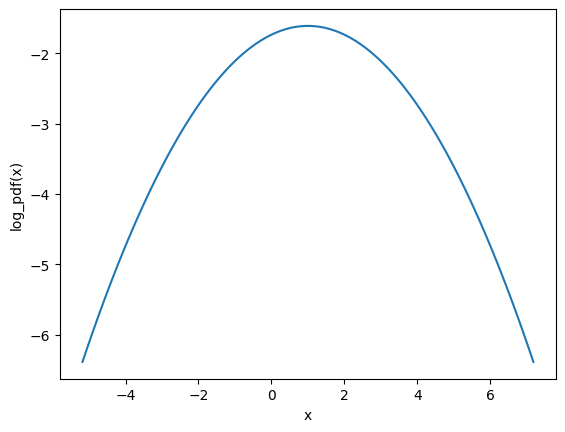

In [48]:
d.plot("log_pdf")

## 3. composite probability distributions <a class="anchor" id="chapter3"></a>

work in progress

## 4. Extension guide - implementing your own probabilisty distribution <a class="anchor" id="chapter4"></a>


`skpro` is meant to be easily extensible, for direct contribution to `skpro` as well as for local/private extension with custom methods.

To get started:

* Follow the ["implementing estimator" developer guide](https://skpro.readthedocs.io/en/stable/developer_guide/add_estimators.html)
* Use the [probabilistic regressor template](https://github.com/sktime/skpro/blob/main/extension_templates/regression.py) to get started

1. Read through the [probability distibution extension template](https://github.com/sktime/skpro/blob/main/extension_templates/distributions.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. Copy the distribution extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `skpro` or affiliated repository (if contributed extension), inside `skpro.distributions`; rename the file and update the file docstring appropriately.
3. Address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, and as many methods as possible, most importantly `_ppf`, and possibly other common methods such as `_pdf` or `_pmf`, `_cdf`. You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
4. To test your estimator manually: import your estimator and run it in the worfklows in Section 1; then use it in the compositors in Section 3.
5. To test your estimator automatically: call `skpro.utils.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `skpro` or one of its affiliated packages, additionally:

* Add yourself as an author to the code, and to the `CODEOWNERS` for the new estimator file(s).
* Create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* In the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* Before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

## 5. Summary<a class="anchor" id="chapter5"></a>

* `skpro` provides a unified interface for probability distributions, with an interface inspired by `scikit-learn` and `pandas`

* `skpro` distributions are parametric first class objects. They are symbolic representations of probability distibution, and come with methods such as `pdf`, `cdf`, `sample`, `plot`, etc

* `skpro` distributions can be scalar-valued, or data frame valued. The latter broadcast parameters and arguments of methods to 2D, and are returned by `skpro` probabilistic regressors or survival regressors `predict_proba`

* `skpro` is easy to extend, and comes with user friendly tools to facilitate implementing and testing your own probability distributions.

---

### Credits:

noteook creation: fkiraly

skpro: https://github.com/sktime/skpro/blob/main/CONTRIBUTORS.md